In [1]:
%run "./02_preprocessing.ipynb"

import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load saved models
lr_model = joblib.load("../models/log_reg.pkl")
svm_model = joblib.load("../models/svm_rbf.pkl")
rf_model = joblib.load("../models/random_forest.pkl")
knn_model = joblib.load("../models/knn_svd.pkl")

print("All models loaded successfully!")


Initial shape: (15000, 17)
Exact duplicate rows: 0
Duplicate faculty_id: 0


,faculty_id,academic_rank,tenure_status,years_at_institution,base_salary,teaching_load,research_funding,institution_type,department_size,admin_support,work_life_balance,department_collaboration,promotion_opportunities,publications_last_3_years,student_evaluation_avg,job_market_alternatives,left_institution
0,1,Associate Professor,Tenure-Track,3,70974.758663,6,9960.082453,Community College,Medium,1,3,8,1,7,3.520074,9,0
1,2,Full Professor,Non-Tenure,16,69482.774557,3,108309.536130,Liberal Arts College,Medium,3,3,2,9,4,3.811163,4,0
2,3,Lecturer,Non-Tenure,19,91434.392986,2,10044.468010,Research University,Medium,9,5,9,3,4,3.539667,7,0
3,4,Associate Professor,Non-Tenure,24,65850.710135,6,4159.726828,Research University,Small,5,7,6,1,5,4.351417,9,1
4,5,Associate Professor,Non-Tenure,39,30000.000000,7,10718.111809,Community College,Small,6,6,8,8,5,3.932108,2,0


Train shape: (12000, 15)
Test shape: (3000, 15)

Train target distribution:
left_institution
0    0.726667
1    0.273333
Name: proportion, dtype: float64
Categorical columns: ['academic_rank', 'tenure_status', 'institution_type', 'department_size']
Numeric columns: ['years_at_institution', 'base_salary', 'teaching_load', 'research_funding', 'admin_support', 'work_life_balance', 'department_collaboration', 'promotion_opportunities', 'publications_last_3_years', 'student_evaluation_avg', 'job_market_alternatives']
Preprocessor fitted successfully!
Processed shape: (12000, 40)
All models loaded successfully!


In [3]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
voting_clf = VotingClassifier(
    estimators=[
        ('lr', lr_model),
        ('svm', svm_model),
        ('rf', rf_model),
        ('knn', knn_model)
    ],
    voting='soft',
    weights=[1, 2, 3, 1]
)

voting_clf.fit(X_train, y_train)

y_pred_vote = voting_clf.predict(X_test)
y_prob_vote = voting_clf.predict_proba(X_test)[:, 1]

print("Voting Accuracy:", accuracy_score(y_test, y_pred_vote))
print("Voting AUC:", roc_auc_score(y_test, y_prob_vote))
print("\nClassification Report:\n", classification_report(y_test, y_pred_vote))


Voting Accuracy: 0.7576666666666667
Voting AUC: 0.7901353770418438

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.86      0.84      2180
           1       0.56      0.50      0.53       820

    accuracy                           0.76      3000
   macro avg       0.69      0.68      0.68      3000
weighted avg       0.75      0.76      0.75      3000



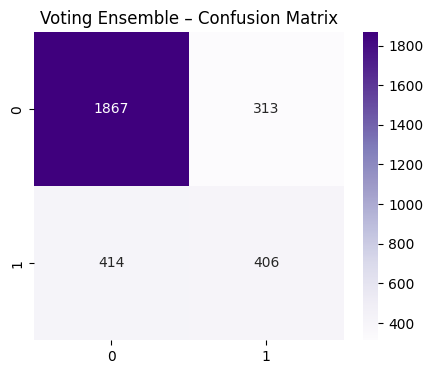

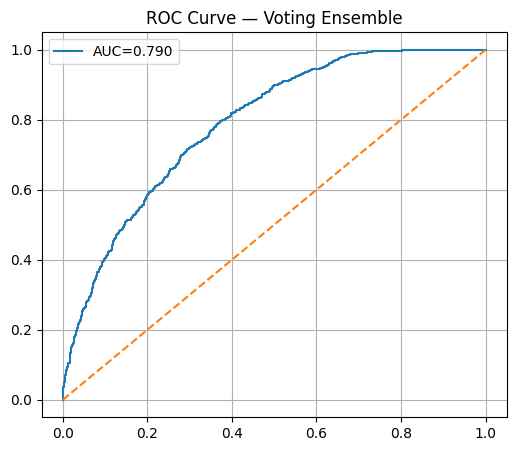

In [5]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred_vote)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples")
plt.title("Voting Ensemble – Confusion Matrix")
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_prob_vote)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC={roc_auc_score(y_test, y_prob_vote):.3f}")
plt.plot([0,1],[0,1],"--")
plt.title("ROC Curve — Voting Ensemble")
plt.legend()
plt.grid(True)
plt.show()


In [1]:
from sklearn.ensemble import StackingClassifier, GradientBoostingClassifier

stack_clf = StackingClassifier(
    estimators=[
        ('lr', lr_model),
        ('svm', svm_model),
        ('rf', rf_model),
        ('knn', knn_model)
    ],
    final_estimator=GradientBoostingClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=3,
        random_state=42
    ),
    passthrough=True,
    n_jobs=-1
)

stack_clf.fit(X_train, y_train)

y_pred_stack = stack_clf.predict(X_test)
y_prob_stack = stack_clf.predict_proba(X_test)[:, 1]

print("Stacking Accuracy:", accuracy_score(y_test, y_pred_stack))
print("Stacking AUC:", roc_auc_score(y_test, y_prob_stack))
print("\nStacking Report:\n", classification_report(y_test, y_pred_stack))


NameError: name 'lr_model' is not defined